# 3. Dataset Statistics

Code used to gather dataset statistics and generate plots.

## Loading Data

### Setup

In [4]:
from collections import defaultdict as dd
from csv import reader as csv_reader
from datetime import datetime as dt
from enum import Enum
from iso639 import languages
import pandas as pd

In [5]:
DIR = '../data/prepared/'
PATH_FRIENDS = DIR + 'friends.csv'
PATH_GROUPS  = DIR + 'groups.csv'
PATH_REVIEWS = DIR + 'reviews/%d.csv'
PATH_LANGS   = DIR + 'reviews/languages/%d.csv'
REVIEW_PAGES = 32
LANGS_PAGES  = 21

### Friend Data

In [6]:
def load_friend_data():
    friend_graph = dd(set)
    with open(PATH_FRIENDS, 'r', encoding='utf-8', newline='') as f:
        reader = csv_reader(f, delimiter=',')
        for row in reader:
            user = int(row[0])
            friends = list(map(int, row[1:]))
            for friend in friends:
                friend_graph[user].add(friend)
                friend_graph[friend].add(user)
    return friend_graph

### Group Data

In [7]:
def load_group_data():
    group_users = dd(set)
    user_groups = dd(set)
    with open(PATH_GROUPS, 'r', encoding='utf-8', newline='') as f:
        reader = csv_reader(f, delimiter=',')
        for row in reader:
            user = int(row[0])
            groups = list(map(int, row[1:]))
            for group in groups:
                user_groups[user].add(group)
                group_users[group].add(user)
    return group_users, user_groups

### Review Data

#### General Data

In [8]:
class ReviewData(Enum):
    UserReviews = 0
    UserPolarities = 1
    GameReviews = 2
    Counts = 3
    ReviewDates = 4
    ReviewPlaytimes = 5
    ReviewVotes = 6

def load_review_data(review_data):
    user_reviews = dd(int)
    user_polarities = dd(lambda: [0, 0])
    game_reviews = dd(int)
    counts = {
        'polarity': [0, 0],
        'early': [0, 0],
        'updated': [0, 0]
    }
    review_dates = dd(int)
    review_playtimes = []
    review_votes = {
        'up': [],
        'funny': []
    }
    for page_num in range(1, REVIEW_PAGES + 1):
        with open(PATH_REVIEWS % page_num, 'r', encoding='utf-8', newline='') as f:
            reader = csv_reader(f, delimiter=',')
            for row in reader:
                if review_data == ReviewData.UserReviews:
                    user_reviews[int(row[0])] += 1
                elif review_data == ReviewData.UserPolarities:
                    user_polarities[int(row[0])][int(row[2])] += 1
                elif review_data == ReviewData.GameReviews:
                    game_reviews[int(row[1])] += 1
                elif review_data == ReviewData.Counts:
                    counts['polarity'][int(row[2])] += 1
                    counts['early'][int(row[3])] += 1
                    is_updated = int(row[6]) != int(row[7])
                    counts['updated'][int(is_updated)] += 1
                elif review_data == ReviewData.ReviewDates:
                    date = dt.fromtimestamp(int(row[6]))
                    review_dates[(date.year, date.month)] += 1
                elif review_data == ReviewData.ReviewPlaytimes:
                    review_playtimes.append(float(row[5]))
                else:
                    review_votes['up'].append(int(row[8]))
                    review_votes['funny'].append(int(row[9]))
    if review_data == ReviewData.UserReviews:
        return user_reviews
    elif review_data == ReviewData.UserPolarities:
        return user_polarities
    elif review_data == ReviewData.GameReviews:
        return game_reviews
    elif review_data == ReviewData.Counts:
        return counts
    elif review_data == ReviewData.ReviewDates:
        return review_dates
    elif review_data == ReviewData.ReviewPlaytimes:
        return review_playtimes
    else:
        return review_votes

#### Language Data

In [9]:
def load_review_language_data():
    df = pd.concat((
        pd.read_csv(PATH_LANGS % page_num, header=None) for page_num in range(1, LANGS_PAGES + 1)
    )).reset_index(drop=True)
    df.columns = ['lang', 'score', 'nlp_words', 'raw_words', 'raw_chars']
    return df

## Plotting Data

### Setup

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator

In [11]:
FONT_SIZE_S = 15
FONT_SIZE_L = 18
TICK_DIR = 'in'
TICK_SIZE_S = 3.0
TICK_SIZE_L = 5.0

def init_plt():
    plt.style.use('default')
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = FONT_SIZE_S
    plt.rcParams['legend.fontsize'] = FONT_SIZE_S
    plt.rcParams['xtick.direction'] = TICK_DIR
    plt.rcParams['ytick.direction'] = TICK_DIR
    plt.rcParams['xtick.major.size'] = TICK_SIZE_L
    plt.rcParams['xtick.minor.size'] = TICK_SIZE_S
    plt.rcParams['ytick.major.size'] = TICK_SIZE_L
    plt.rcParams['ytick.minor.size'] = TICK_SIZE_S
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['axes.formatter.limits'] = (-9, 10)
    plt.rcParams['legend.handlelength'] = 2.0
    plt.rcParams['savefig.dpi'] = 400
    plt.rcParams['savefig.bbox'] = 'tight'

def init_ax(ax, only_vertical=False):
    if not only_vertical:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    return ax

init_plt()

In [12]:
DIR_FIGS = '../figures/03_dataset/'

### Helper Functions

In [32]:
def print_stats(X):
    Xnp = np.array(X)
    print('=== STATS REPORT ===')
    print(f'- length={len(X)}')
    print(f'- mean={np.mean(Xnp)}')
    print(f'- std={np.std(Xnp)}')
    print(f'- median={np.median(Xnp)}')
    q75, q25 = np.percentile(Xnp, [75, 25])
    print(f'- q75={q75}, q25={q25}, iqr={q75 - q25}')

In [13]:
def exclude_outliers_iqr(X, scale=1.5, verbose=False):
    X.sort()
    N = len(X)
    q1 = X[int(N * 0.25)]
    q3 = X[int(N * 0.75)]
    iqr = (q3 - q1) * scale
    min_value = q1 - iqr
    max_value = q3 + iqr
    start_ix = 0
    end_ix = N - 1
    while X[start_ix] < min_value:
        start_ix += 1
    while X[end_ix] > max_value:
        end_ix -= 1
    N_excl = start_ix + (N - end_ix)
    if verbose:
        print ('=== OUTLIER REPORT ===')
        print(f'- excluded {N_excl} out of {N} ({N_excl / N})')
        print(f'- min_old={X[0]}, max_old={X[-1]}')
        print(f'- min_new={X[start_ix]}, max_new={X[end_ix]}')
    return X[start_ix:end_ix]

In [14]:
def get_groupless_user_count(user_groups, friend_graph):
    count = 0
    for user in friend_graph.keys():
        if user not in user_groups:
            count += 1
    return count

In [15]:
def get_yearly_counts_from_monthly(review_dates):
    N = 12
    X, Y = list(range(N)), [0] * N
    labels = [str(y) for y in range(2010, 2022)]
    for key, value in review_dates.items():
        Y[key[0] - 2010] += value
    return X, Y, labels

In [16]:
def get_language_name_from_code(code):
    if code == 'UNKNOWN': return 'Unknown'
    elif code == 'zh-cn': return 'Chinese$^*$'
    elif code == 'zh-tw': return 'Chinese$^**$'
    else: return languages.get(alpha2=code).name

### Friend Data

In [31]:
def plot_friend_hist(friend_graph):
    # convert to an array of data
    X = []
    for friends in friend_graph.values():
        X.append(len(friends))
    # print stats
    print_stats(X)
    # exclude outliers
    X = exclude_outliers_iqr(X, scale=3.0, verbose=True)
    return
    # dynamic bins choice
    num_bins = X[-1]
    # plot histogram
    ax = plt.gca()
    ax = init_ax(ax)
    plt.hist(X, bins=num_bins, color='grey')
    plt.xlabel('Number of friends')
    plt.ylabel('Users')
    plt.savefig(DIR_FIGS + '01_hist_friends.png')
    plt.show()

In [28]:
friend_graph = load_friend_data()

In [33]:
plot_friend_hist(friend_graph)

=== STATS REPORT ===
- length=4183276
- mean=28.47915126804925
- std=46.964504216250766
- median=16.0
- q75=35.0, q25=7.0, iqr=28.0
=== OUTLIER REPORT ===
- excluded 110320 out of 4183276 (0.026371676169585752)
- min_old=1, max_old=2053
- min_new=1, max_new=119


### Group Data

#### Group Users

In [37]:
def plot_group_users_hist(group_users):
    # convert to an array of data
    X = []
    for users in group_users.values():
        X.append(len(users))
    # print stats
    print_stats(X)
    # exclude outliers
    X = exclude_outliers_iqr(X, scale=4.5, verbose=True)
    return
    # dynamic bins choice
    num_bins = X[-1]
    # plot histogram
    ax = plt.gca()
    ax = init_ax(ax)
    plt.hist(X, bins=num_bins, color='grey')
    plt.xlabel('Number of members')
    plt.ylabel('Groups')
    plt.savefig(DIR_FIGS + '02_hist_group_users.png')
    plt.show()

In [35]:
group_users, user_groups = load_group_data()

In [42]:
plot_group_users_hist(group_users)

=== STATS REPORT ===
- length=5981137
- mean=8.97812221990568
- std=339.29011304305214
- median=1.0
- q75=3.0, q25=1.0, iqr=2.0
=== OUTLIER REPORT ===
- excluded 337472 out of 5981137 (0.056422716951643144)
- min_old=1, max_old=310646
- min_new=1, max_new=12


#### User Groups

In [38]:
def plot_user_groups_hist(user_groups, friend_graph):
    # calculate the number of groupless users
    groupless_count = get_groupless_user_count(user_groups, friend_graph)
    # convert to an array of data
    X = [0] * groupless_count
    for groups in user_groups.values():
        X.append(len(groups))
    # print stats
    print_stats(X)
    # exclude outliers
    X = exclude_outliers_iqr(X, scale=3.0, verbose=True)
    return
    # dynamic bins choice
    # +1 to account for 0 needing a bin too
    num_bins = X[-1] + 1
    # plot histogram
    ax = plt.gca()
    ax = init_ax(ax)
    plt.hist(X, bins=num_bins, color='grey')
    plt.xlabel('Number of groups')
    plt.ylabel('Users')
    plt.savefig(DIR_FIGS + '03_hist_user_groups.png')
    plt.show()

In [43]:
plot_user_groups_hist(user_groups, friend_graph)

=== STATS REPORT ===
- length=4183276
- mean=12.836680869251754
- std=37.23680180993714
- median=4.0
- q75=12.0, q25=1.0, iqr=11.0
=== OUTLIER REPORT ===
- excluded 229697 out of 4183276 (0.05490840193188305)
- min_old=0, max_old=2224
- min_new=0, max_new=45


### Review Data

#### User Reviews

In [44]:
def plot_user_reviews_hist(user_reviews):
    # convert to an array of data
    X = []
    for reviews in user_reviews.values():
        X.append(reviews)
    # print stats
    print_stats(X)
    # exclude outliers
    X = exclude_outliers_iqr(X, scale=6.0, verbose=True)
    return
    # dynamic bins choice
    num_bins = X[-1]
    # plot histogram
    ax = plt.gca()
    ax = init_ax(ax)
    plt.hist(X, bins=num_bins, color='grey')
    plt.xlabel('Number of reviews')
    plt.ylabel('Users')
    plt.savefig(DIR_FIGS + 'hist_user_reviews.png')
    plt.show()

In [45]:
user_reviews = load_review_data(ReviewData.UserReviews)

In [47]:
del user_reviews

In [46]:
plot_user_reviews_hist(user_reviews)

=== STATS REPORT ===
- length=2049646
- mean=4.655833739094458
- std=16.862597122000142
- median=2.0
- q75=4.0, q25=1.0, iqr=3.0
=== OUTLIER REPORT ===
- excluded 63972 out of 2049646 (0.031211243307380884)
- min_old=1, max_old=5235
- min_new=1, max_new=22


#### Game Reviews

In [40]:
def plot_game_reviews_hist(game_reviews):
    # convert to an array of data
    X = []
    for reviews in game_reviews.values():
        X.append(reviews)
    # print stats
    print_stats(X)
    # exclude outliers
    X = exclude_outliers_iqr(X, scale=4.5, verbose=True)
    return
    # dynamic bins choice
    num_bins = X[-1] // 2
    # plot histogram
    ax = plt.gca()
    ax = init_ax(ax)
    plt.hist(X, bins=num_bins, color='grey')
    plt.xlabel('Number of reviews')
    plt.ylabel('Games')
    plt.savefig(DIR_FIGS + 'hist_game_reviews.png')
    plt.show()

In [48]:
game_reviews = load_review_data(ReviewData.GameReviews)

In [50]:
del game_reviews

In [49]:
plot_game_reviews_hist(game_reviews)

=== STATS REPORT ===
- length=57631
- mean=165.58468532560602
- std=3611.086909627601
- median=7.0
- q75=31.0, q25=2.0, iqr=29.0
=== OUTLIER REPORT ===
- excluded 5034 out of 57631 (0.087348822682237)
- min_old=1, max_old=753161
- min_new=1, max_new=161


#### User Polarities

In [51]:
def plot_user_polarities_hist(user_polarities, min_reviews=1):
    # convert to an array of data
    X = []
    for user_polarity in user_polarities.values():
        count_down, count_up = user_polarity
        if count_down + count_up < min_reviews: continue
        percent = count_up / (count_down + count_up)
        X.append(percent)
    # print stats
    print_stats(X)
    return
    # plot histogram
    ax = plt.gca()
    ax = init_ax(ax)
    plt.hist(X, bins=20, color='grey')
    if min_reviews == 1:
        plt.xlabel(f'Proportion positive reviews')
    else:
        plt.xlabel(f'Proportion positive reviews ($\ge 5$ reviews)')
    plt.ylabel('Users')
    plt.savefig(DIR_FIGS + f'hist_user_polarities_min{min_reviews}.png')
    plt.show()

In [52]:
user_polarities = load_review_data(ReviewData.UserPolarities)

In [54]:
del user_polarities

In [53]:
plot_user_polarities_hist(user_polarities)
plot_user_polarities_hist(user_polarities, min_reviews=5)

=== STATS REPORT ===
- length=2049646
- mean=0.8858035956954274
- std=0.25195974192446213
- median=1.0
- q75=1.0, q25=0.9318181818181818, iqr=0.06818181818181823
=== STATS REPORT ===
- length=444863
- mean=0.8584297413722493
- std=0.16575808776142945
- median=0.9
- q75=1.0, q25=0.8, iqr=0.19999999999999996


#### Counts

In [23]:
def plot_counts_bars(counts):
    # calc and print values
    num_neg, num_pos = counts['polarity']
    pct_neg = round(num_neg / (num_neg + num_pos), 3)
    pct_pos = round(num_pos / (num_neg + num_pos), 3)
    num_nea, num_ea = counts['early']
    pct_nea = round(num_nea / (num_nea + num_ea), 3)
    pct_ea = round(num_ea / (num_nea + num_ea), 3)
    num_nupd, num_upd = counts['updated']
    pct_nupd = round(num_nupd / (num_nupd + num_upd), 3)
    pct_upd = round(num_upd / (num_nupd + num_upd), 3)
    print('=== Counts ===')
    print(f'Pol: pos={num_pos}, %pos={pct_pos}, neg={num_neg}, %neg={pct_neg}')
    print(f'EA: ea={num_ea}, %ea={pct_ea}, nea={num_not_ea}, %nea={pct_nea}')
    print(f'Upd: upd={num_upd}, %upd={pct_upd}, nupd={num_nupd}, %nupd={pct_nupd}')
    # plot values
    X = np.arange(3)
    plt.rcParams['xtick.direction'] = 'out'
    ax = plt.gca()
    ax = init_ax(ax, only_vertical=True)
    plt.bar(X + 0.00, [pct_pos, pct_ea, pct_upd], color='dimgrey', width=0.33)
    plt.bar(X + 0.33, [pct_neg, pct_nea, pct_nupd], color='darkgrey', width=0.33)
    plt.xlim([-0.66, 3.0])
    plt.ylim([0, 1])
    plt.xticks([0.166, 1.166, 2.166], ['Voted Up', 'Early Access', 'Was Updated'])
    plt.ylabel('Percentage')
    plt.legend(['Yes', 'No'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig(DIR_FIGS + 'bars_counts.png')
    plt.show()
    init_plt()

In [451]:
counts = load_review_data(ReviewData.Counts)

In [352]:
del counts

=== Counts ===
Pol: pos=8113706, %pos=0.85, neg=1429105, %neg=0.15
EA: ea=918570, %ea=0.096, nea=8624241, %nea=0.904
Upd: upd=1374710, %upd=0.144, nupd=8168101, %nupd=0.856


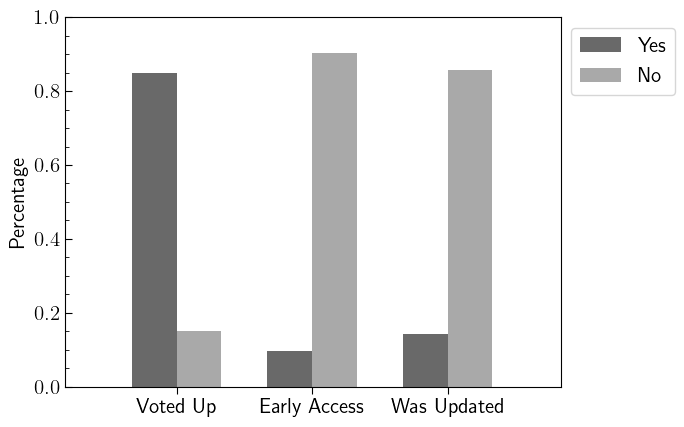

In [460]:
plot_counts_bars(counts)

#### Dates

In [463]:
def plot_review_dates_bars(review_dates):
    X, Y, labels = get_yearly_counts_from_monthly(review_dates)
    plt.rcParams['xtick.direction'] = 'out'
    ax = plt.gca()
    ax = init_ax(ax, only_vertical=True)
    plt.bar(X, Y, color='grey', tick_label=labels)
    plt.xticks(rotation='vertical')
    plt.xlabel('Year')
    plt.ylabel('Reviews')
    plt.savefig(DIR_FIGS + 'bars_review_dates.png')
    plt.show()
    init_plt()

In [55]:
review_dates = load_review_data(ReviewData.ReviewDates)

In [56]:
del review_dates

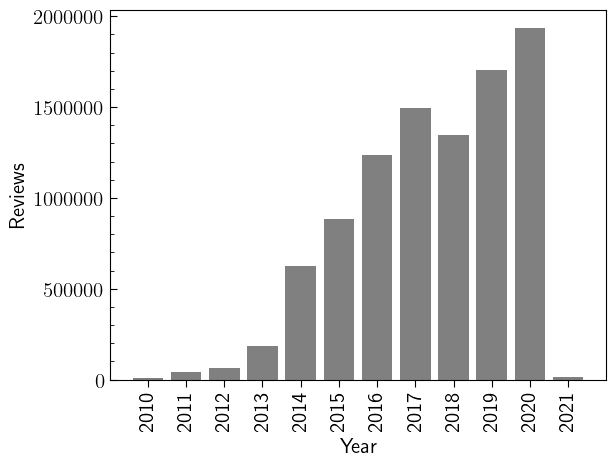

In [464]:
plot_review_dates_bars(review_dates)

#### Playtimes

In [57]:
def plot_review_playtimes_hist(review_playtimes):
    X = review_playtimes
    # print stats
    print_stats(X)
    # exclude outliers
    X = exclude_outliers_iqr(X, scale=1.5, verbose=True)
    return
    X = list(map(round, X))
    # dynamic bins choice
    num_bins = X[-1] // 2
    # plot histogram
    ax = plt.gca()
    ax = init_ax(ax)
    plt.hist(X, bins=num_bins, color='grey')
    plt.xlabel('Hours played')
    plt.ylabel('Reviews')
    plt.savefig(DIR_FIGS + 'hist_review_playtimes.png')
    plt.show()

In [58]:
review_playtimes = load_review_data(ReviewData.ReviewPlaytimes)

In [62]:
del review_playtimes

In [61]:
plot_review_playtimes_hist(review_playtimes)

=== STATS REPORT ===
- length=9542811
- mean=159.11410520443067
- std=540.6030757956179
- median=12.2
- q75=62.7, q25=2.9, iqr=59.800000000000004
=== OUTLIER REPORT ===
- excluded 1573427 out of 9542811 (0.1648808721036181)
- min_old=0.0, max_old=63559.6
- min_new=0.0, max_new=152.4


#### Votes Up

In [59]:
def plot_review_votes_hist(review_votes):
    X = review_votes['up']
    # print stats
    print_stats(X)
    # exclude outliers
    X = exclude_outliers_iqr(X, scale=7.5, verbose=True)
    return
    # dynamic bins choice
    num_bins = X[-1] + 1
    # plot histogram
    ax = plt.gca()
    ax = init_ax(ax)
    plt.hist(X, bins=num_bins, color='grey')
    plt.xlabel('Votes Up')
    plt.ylabel('Reviews')
    plt.savefig(DIR_FIGS + 'hist_review_votes.png')
    plt.show()

In [63]:
review_votes = load_review_data(ReviewData.ReviewVotes)

In [66]:
del review_votes

In [64]:
plot_review_votes_hist(review_votes)

=== STATS REPORT ===
- length=9542811
- mean=4.32535832471166
- std=22.96303456128898
- median=0.0
- q75=2.0, q25=0.0, iqr=2.0
=== OUTLIER REPORT ===
- excluded 431702 out of 9542811 (0.045238452275749776)
- min_old=0, max_old=999
- min_new=0, max_new=17


#### Language

In [26]:
def plot_review_langs_bars(review_langs, min_words=0, min_pct=0.01):
    df = review_langs[review_langs['nlp_words'] >= min_words].groupby(['lang']).size().reset_index(name='freq')
    df['lang'] = df['lang'].apply(get_language_name_from_code)
    df['freq_pct'] = df['freq'] / df['freq'].sum()
    df = df[df['freq_pct'] > 0.01].sort_values(by='freq_pct', ascending=False)
    plt.rcParams['xtick.direction'] = 'out'
    ax = plt.gca()
    ax = init_ax(ax, only_vertical=True)
    plt.bar(df['lang'], df['freq_pct'], color='grey')
    plt.xticks(rotation='vertical')
    plt.xlabel('Language')
    if min_words > 0: plt.ylabel(f'Proportion of reviews ($\\ge {min_words}$ words)')
    else: plt.ylabel('Proportion of reviews')
    plt.savefig(DIR_FIGS + f'bars_review_langs_min{min_words}.png')
    plt.show()
    init_plt()

In [65]:
def plot_review_words_hist(review_langs, code='en'):
    X = list(review_langs[review_langs['lang'] == code]['nlp_words'])
    # print stats
    print_stats(X)
    # exclude outliers
    X = exclude_outliers_iqr(X, scale=4.5, verbose=True)
    return
    num_bins = X[-1]
    plt.rcParams['xtick.direction'] = 'out'
    ax = plt.gca()
    ax = init_ax(ax, only_vertical=True)
    plt.hist(X, bins=num_bins, color='grey')
    plt.xticks(rotation='vertical')
    plt.xlabel(f'Word count ({get_language_name_from_code(code)} reviews)')
    plt.ylabel('Reviews')
    plt.savefig(DIR_FIGS + f'hist_review_words_{code}.png')
    plt.show()
    init_plt()

In [67]:
review_langs = load_review_language_data()

In [69]:
del review_langs

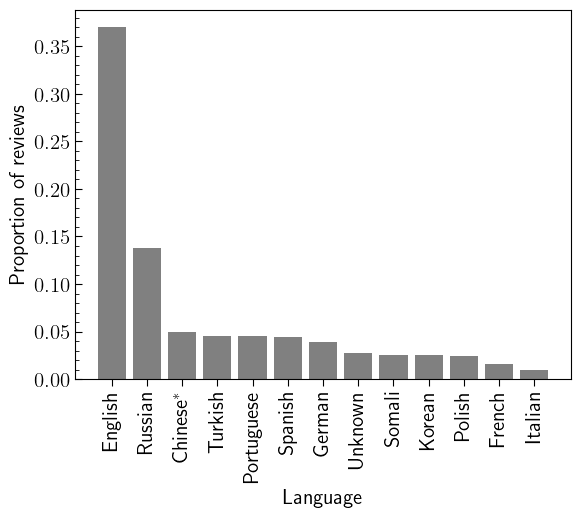

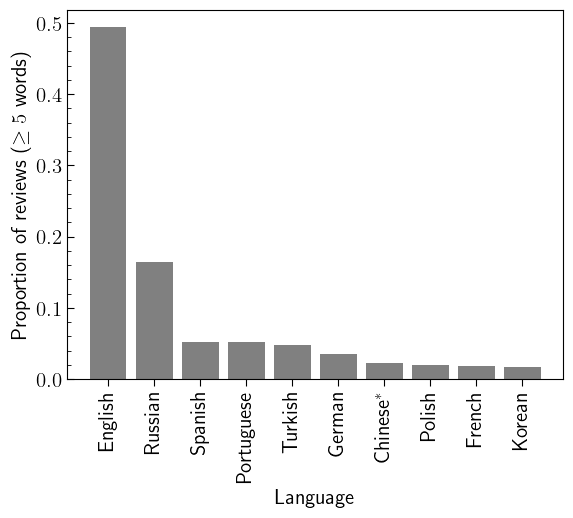

In [735]:
plot_review_langs_bars(review_langs)
plot_review_langs_bars(review_langs, min_words=5)

In [68]:
plot_review_words_hist(review_langs)

=== STATS REPORT ===
- length=2367310
- mean=62.71249139318467
- std=134.34523454796184
- median=20.0
- q75=57.0, q25=8.0, iqr=49.0
=== OUTLIER REPORT ===
- excluded 107397 out of 2367310 (0.0453666820146073)
- min_old=1, max_old=7993
- min_new=1, max_new=277
